In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2

4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


## Reconstruct FTS measurements

In [2]:
kernel = torch.load('../affine_kernel.pt', map_location='cpu')

fts_dir = '20230628_2gratings_mask_data_10000us_talbot_0'

undisp_cube, mask, spectras = hlp.create_bs_data(desired_channels=21,kernel=kernel, fts_dir = fts_dir, cube_dir ='20230629_mask_analysis_800us_talbot_0',  interp_type='average', device='cpu') #here we'll work with synthetic data. 


dataset = hlp.FTSDataset(undispersed_cube=undisp_cube, spectra = spectras,dir = fts_dir,  crop=True, random_shifts=False)

# datasets = hlp.SyntheticDataset(undispersed_cube=undisp_cube,shift_info={'kernel':kernel}, spectra = spectras)


collecting the undispersed cube and spectra.


## Can we reconstruct FTS measurements with a semi learnable kernel?

In [4]:
kernel_learning = True

if kernel_learning:
    model = FourierDenoiser(mask=mask,kernel=kernel,channels=31,CoordGate=False,trainable_kernel=True, name='FTS_unet_trainkern')
    model.load_state_dict(torch.load('../FTS_unet_trainkern',map_location='cpu')); #trained on all data.
    # model.load_state_dict(torch.load('../syn_train_unet',map_location='cpu')); #trained on all data.
    model.kernel_learner = model.kernel_learner.to('cpu')
    model.kernel_learner.kernel = model.kernel_learner.kernel.to('cpu')
    trained_kernel = model.kernel_learner.fill_kernel()
else:
    model = FourierDenoiser(mask=mask,kernel=kernel,CoordGate=False,trainable_kernel=False, name='FTS_unet')
    model.load_state_dict(torch.load('../FTS_unet_rand_shifts',map_location='cpu')); #trained on all data.
    model.kernel = model.kernel.to('cpu')

model = model.to('cpu')
model.eval();
model.mask = model.mask.to('cpu')


RuntimeError: Error(s) in loading state_dict for FourierDenoiser:
	size mismatch for kernel_learner.variable_kernel: copying a param with shape torch.Size([41555]) from checkpoint, the shape in current model is torch.Size([40661]).

In [25]:
x,y  = dataset[[1300,1800]]
y_pred = model(x)


In [21]:
print(model.wiener_noise)

Parameter containing:
tensor([-0.0028], requires_grad=True)


Text(0.5, 1.0, 'Original')

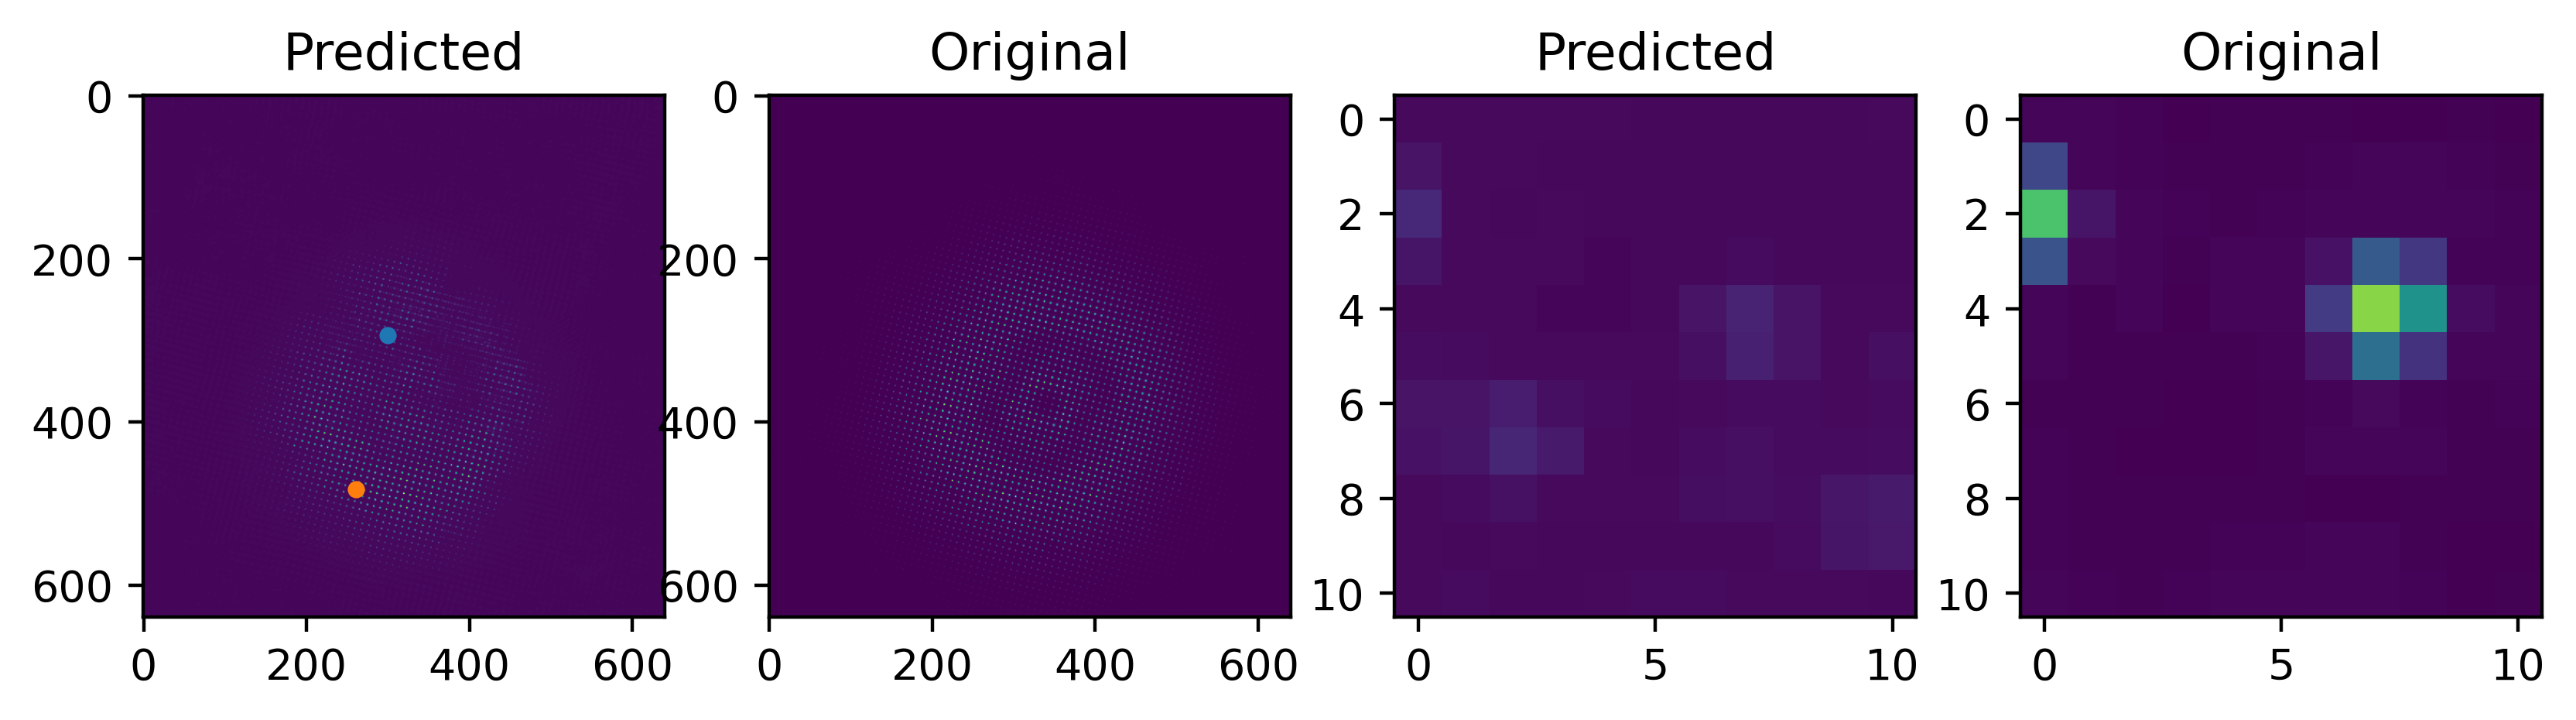

In [28]:
ex = 0

fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=400)
ax[0].imshow(y_pred[ex,10].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[ex,10].cpu().detach().numpy())    ; ax[1].set_title('Original')

coords1 = [294,300]
boxsize = 5

coords2 = [483,261]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')

coords = [coords1,coords2]


coordsno = 0
ax[2].imshow(y_pred[ex,10,coords[coordsno][0]-boxsize:coords[coordsno][0]+boxsize+1,coords[coordsno][1]-boxsize:coords[coordsno][1]+boxsize+1].cpu().detach().numpy(),vmax = y_pred[ex,10].cpu().detach().numpy().max(),vmin = y_pred[ex,10].cpu().detach().numpy().min()); ax[2].set_title('Predicted')
ax[3].imshow(y[ex,10,coords[coordsno][0]-boxsize:coords[coordsno][0]+boxsize+1,coords[coordsno][1]-boxsize:coords[coordsno][1]+boxsize+1].cpu().detach().numpy(),vmax = y[ex,10].cpu().detach().numpy().max(),vmin = y[ex,10].cpu().detach().numpy().min())   ; ax[3].set_title('Original')



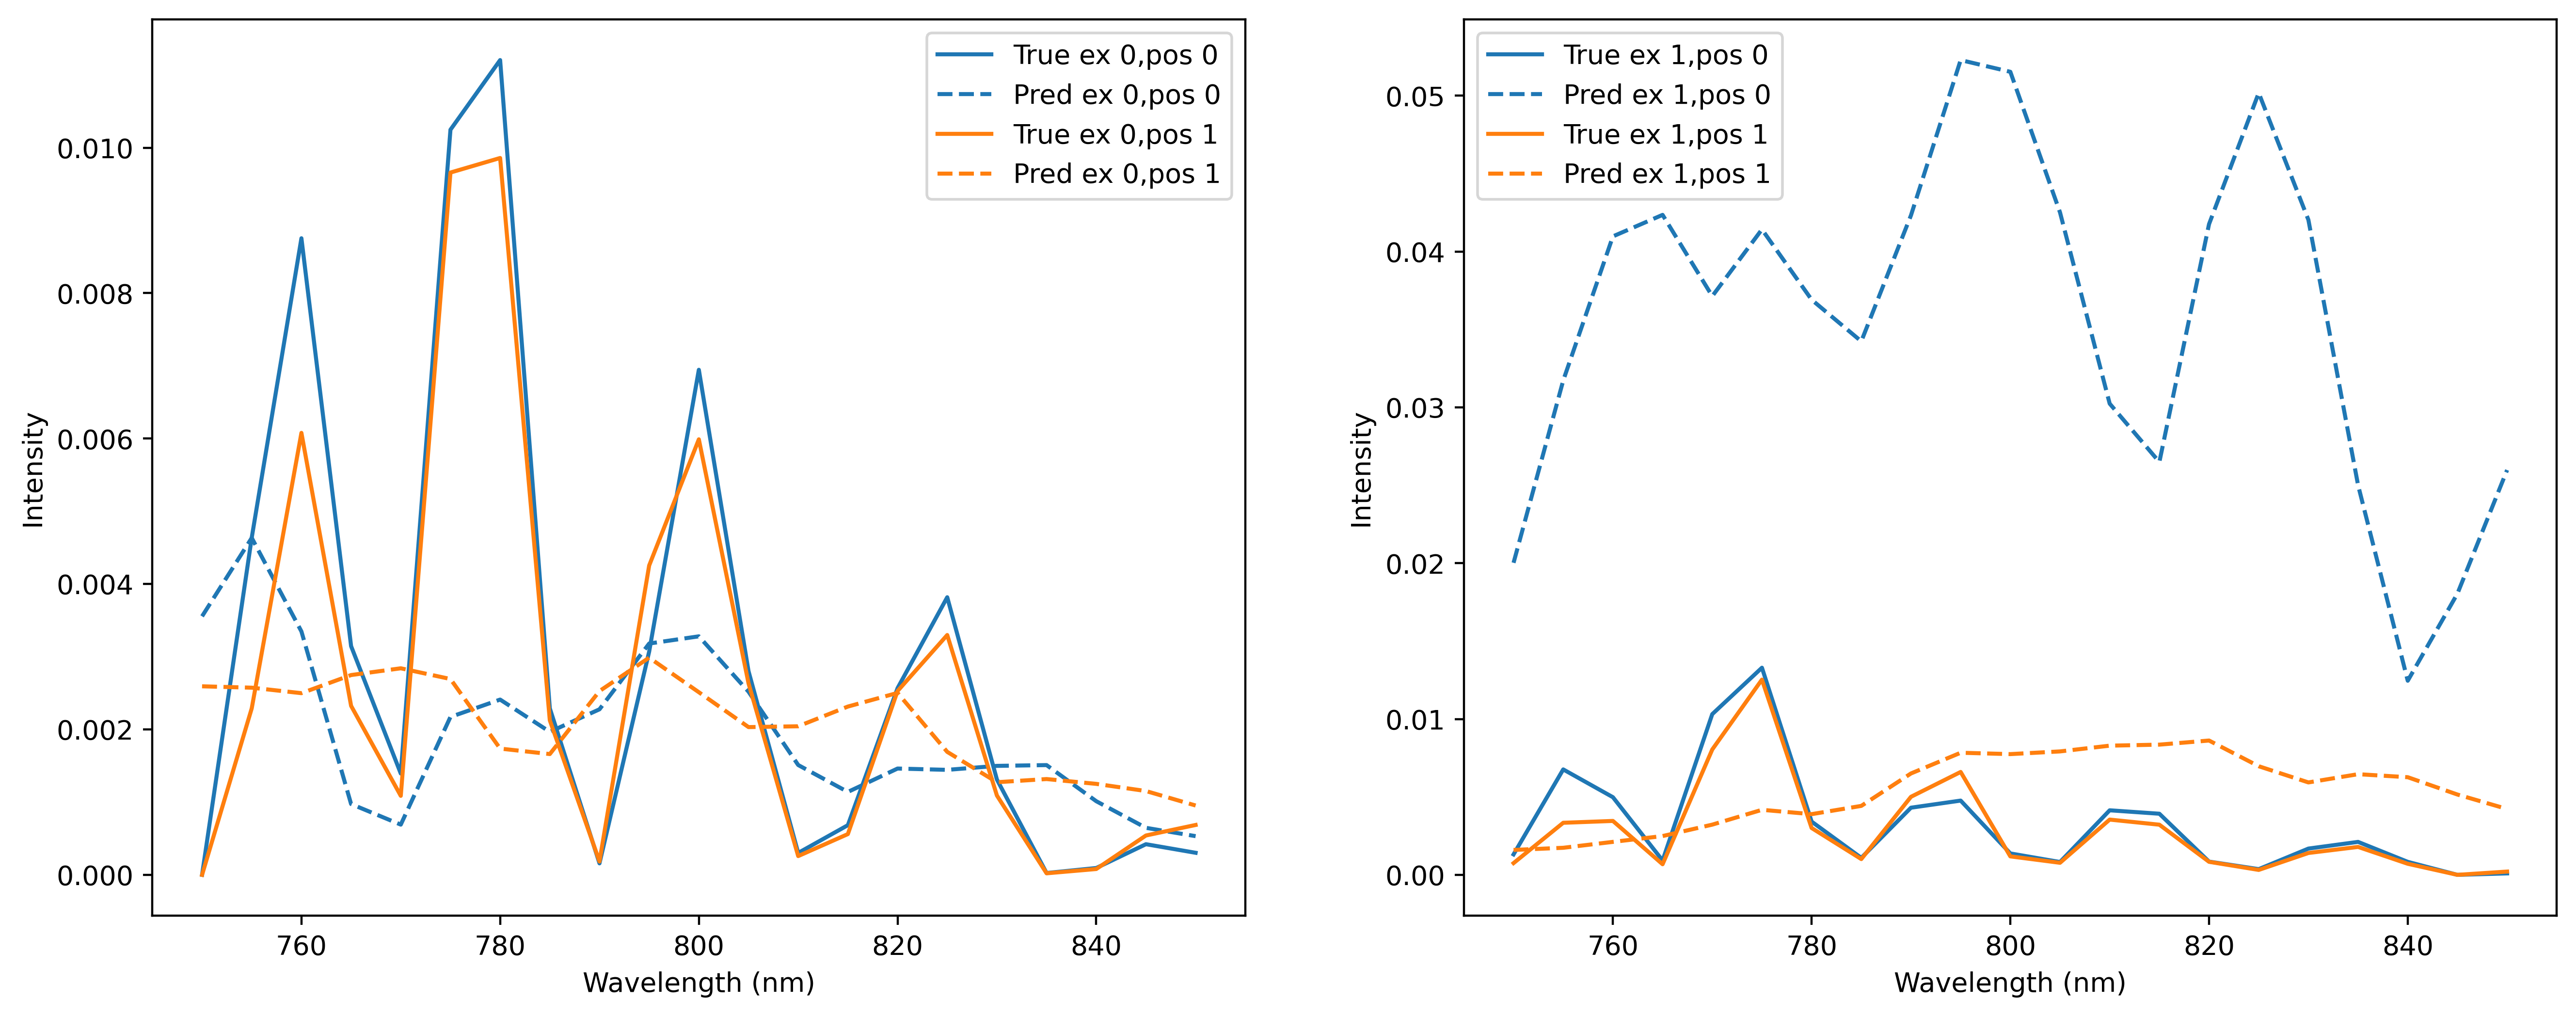

In [27]:
wls = np.linspace(750,850,21)


fig,ax = plt.subplots(1,2,dpi=400,figsize=(16,6))



for j in range(2):
        
        for i in range(2):
                line, = ax[j].plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
                ax[j].plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')

        ax[j].set_xlabel('Wavelength (nm)')
        ax[j].set_ylabel('Intensity')
        ax[j].legend()
        


In [207]:
pos = findclusters(kernel.cpu(),threshold=0.03, padding=150,type='boxes')

Text(0.5, 1.0, 'Trainable region')

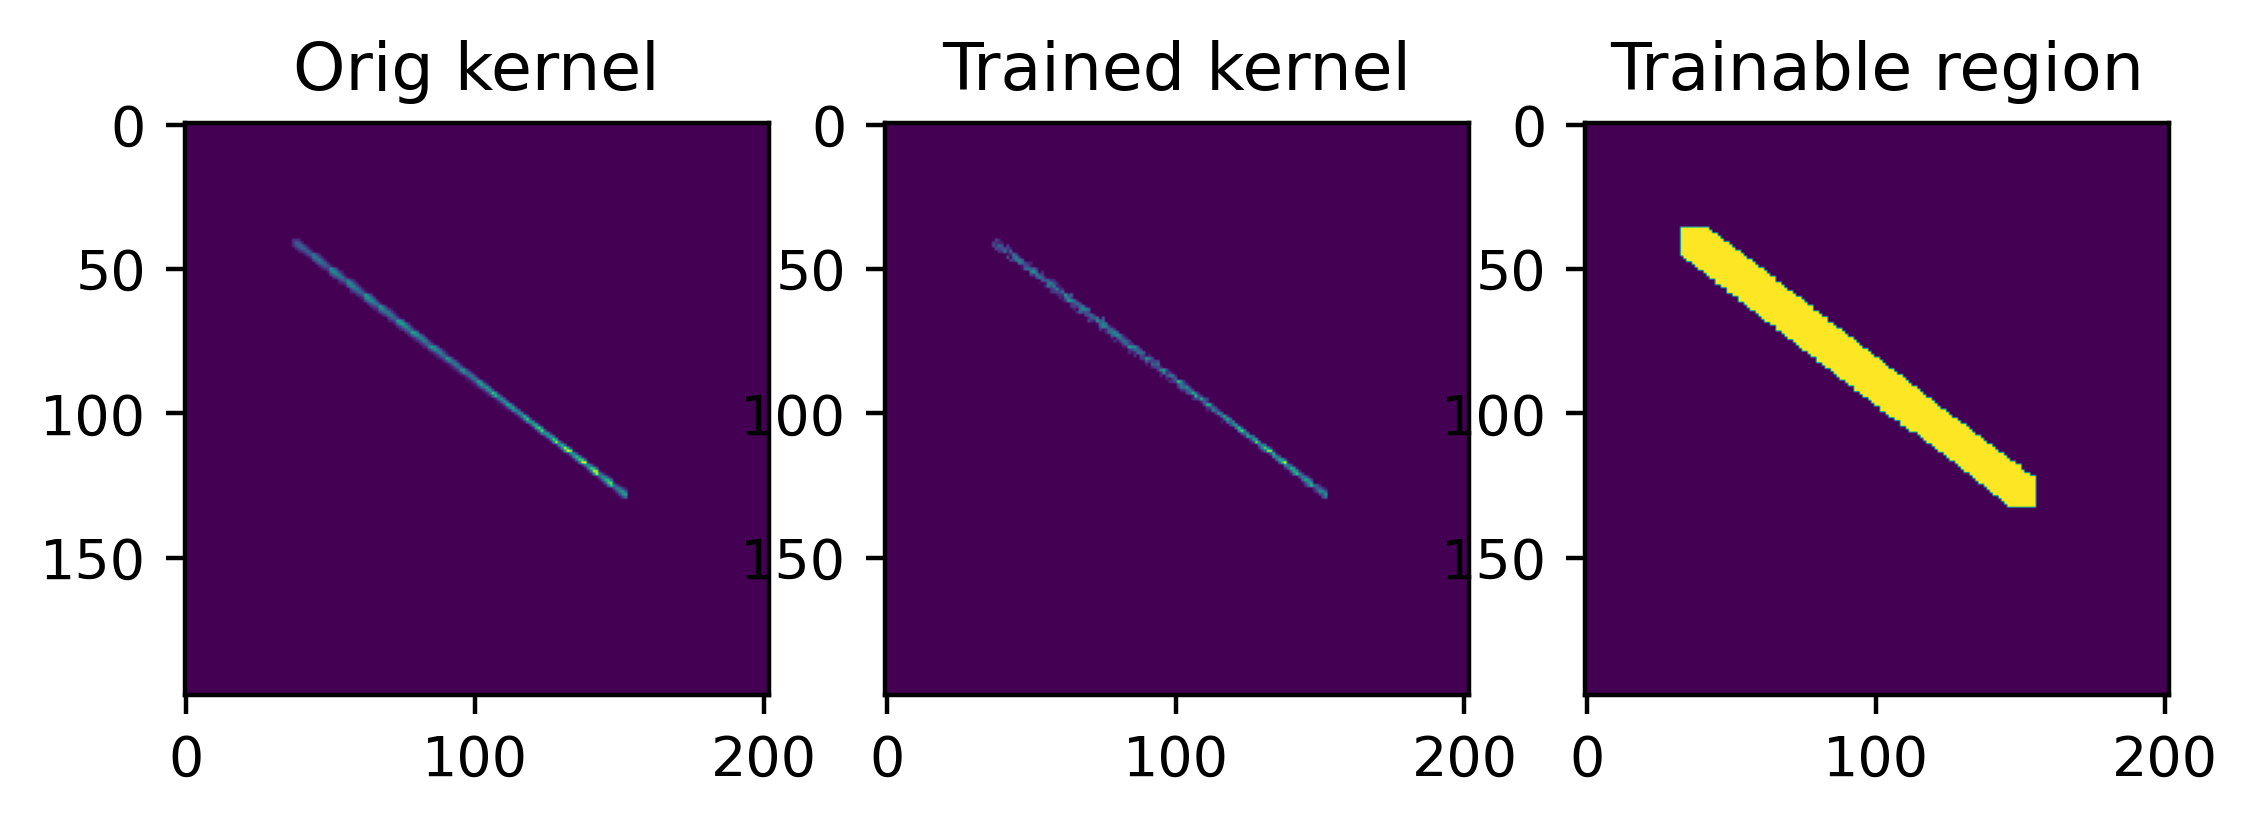

In [208]:
bx = pos[0,0]
by = pos[0,1]

bx[0] += 100
bx[1] -= 100
by[0] += 100
by[1] -= 100

fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(torch.sum(kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0].set_title('Orig kernel')
ax[1].imshow(torch.sum(trained_kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[1].set_title('Trained kernel')
ax[2].imshow((torch.sum(model.kernel_learner.locations,axis=0)>0)[bx[0]:bx[1],by[0]:by[1]]); ax[2].set_title('Trainable region')

Text(0.5, 1.0, 'Trainable region')

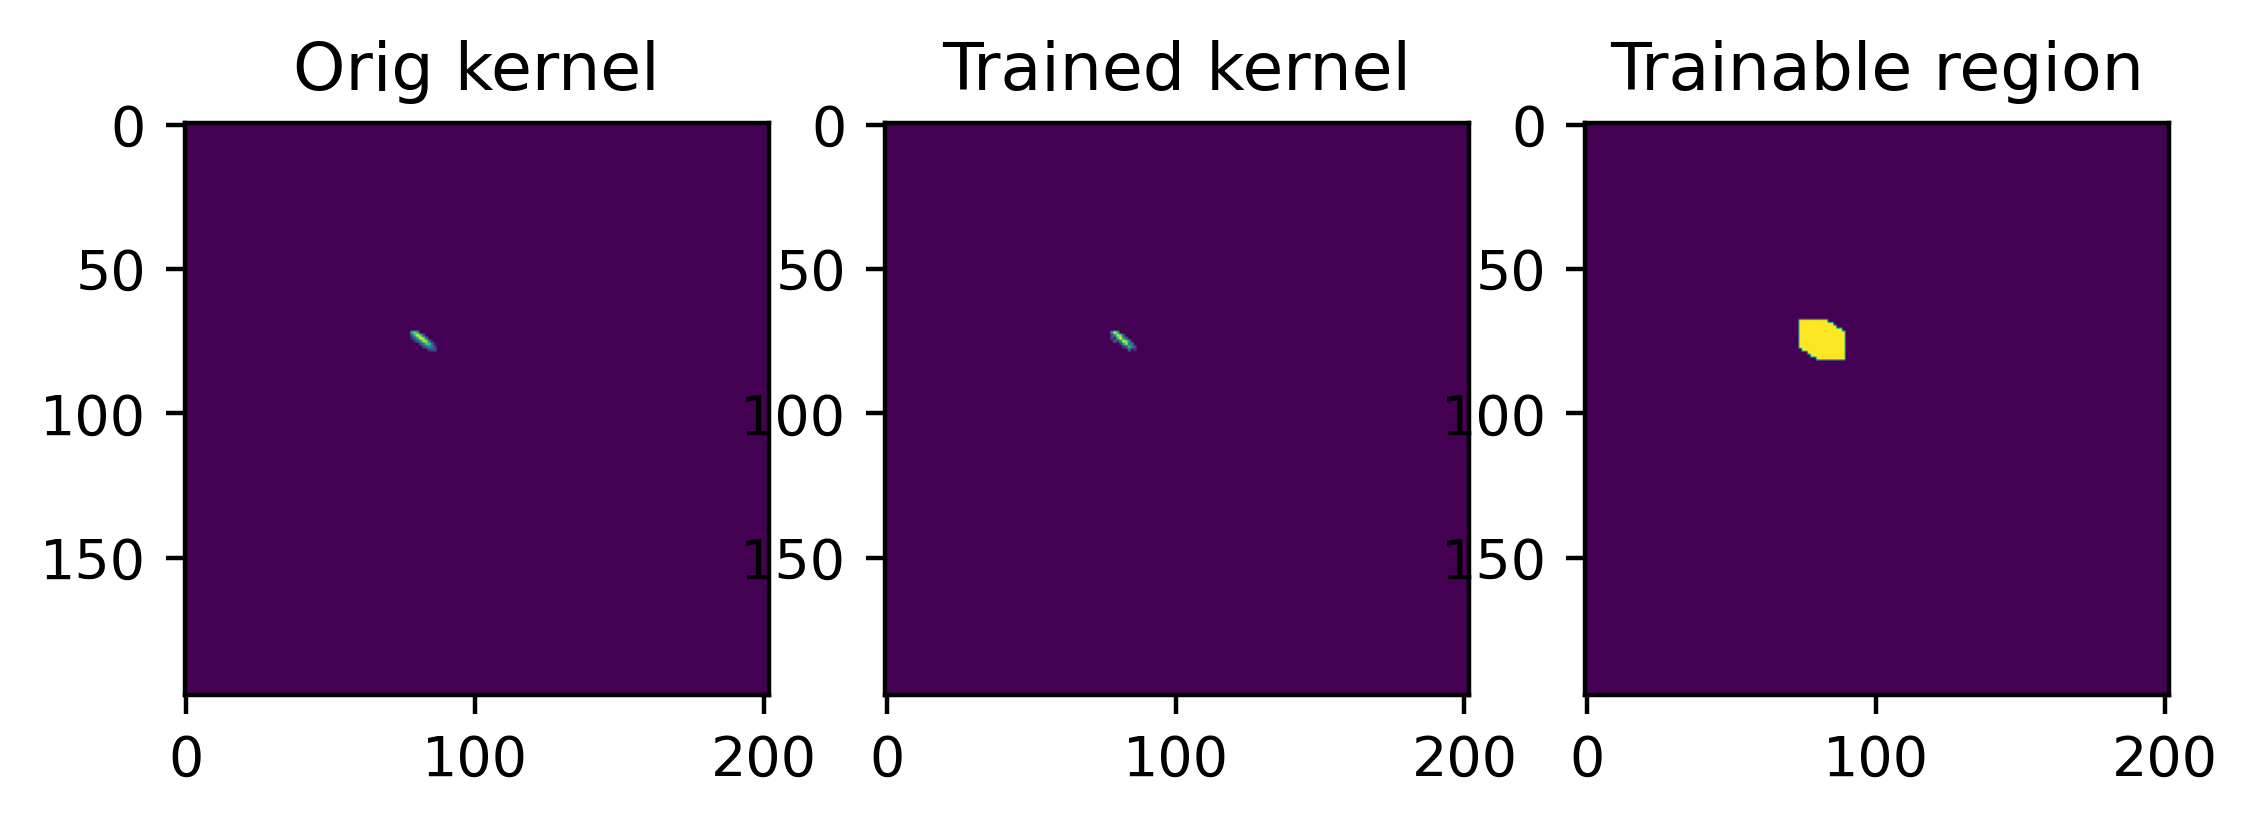

In [209]:
l  = 7

fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(kernel[0,l][bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0].set_title('Orig kernel')
ax[1].imshow(trained_kernel[0,l][bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[1].set_title('Trained kernel')
ax[2].imshow((model.kernel_learner.locations[l]>0)[bx[0]:bx[1],by[0]:by[1]]); ax[2].set_title('Trainable region')